# Part I. ETL Pipeline for Pre-Processing the Files

## PLEASE RUN THE FOLLOWING CODE FOR PRE-PROCESSING THE FILES

#### Import Python packages 

In [1]:
# Import Python packages 
import pandas as pd
import cassandra
import re
import os
import glob
import numpy as np
import json
import csv

#### Creating list of filepaths to process original event csv data files
[Python os.walk()](https://www.decodingdevops.com/python-os-walk-recursive-examples/)

In [2]:
# checking your current working directory
print(os.getcwd())

# Get your current folder and subfolder event data
filepath = os.getcwd() + '/event_data'

# Create a for loop to create a list of files and collect each filepath
for root, dirs, files in os.walk(filepath):
    
# join the file path and roots with the subdirectories using glob
    file_path_list = glob.glob(os.path.join(root,'*'))
    print(file_path_list)

/home/bedo/Data_Engineering_Udacity/Data-Modeling-with-Apache-Cassandra
['/home/bedo/Data_Engineering_Udacity/Data-Modeling-with-Apache-Cassandra/event_data/2018-11-06-events.csv', '/home/bedo/Data_Engineering_Udacity/Data-Modeling-with-Apache-Cassandra/event_data/2018-11-18-events.csv', '/home/bedo/Data_Engineering_Udacity/Data-Modeling-with-Apache-Cassandra/event_data/2018-11-11-events.csv', '/home/bedo/Data_Engineering_Udacity/Data-Modeling-with-Apache-Cassandra/event_data/2018-11-20-events.csv', '/home/bedo/Data_Engineering_Udacity/Data-Modeling-with-Apache-Cassandra/event_data/2018-11-07-events.csv', '/home/bedo/Data_Engineering_Udacity/Data-Modeling-with-Apache-Cassandra/event_data/2018-11-09-events.csv', '/home/bedo/Data_Engineering_Udacity/Data-Modeling-with-Apache-Cassandra/event_data/2018-11-04-events.csv', '/home/bedo/Data_Engineering_Udacity/Data-Modeling-with-Apache-Cassandra/event_data/2018-11-14-events.csv', '/home/bedo/Data_Engineering_Udacity/Data-Modeling-with-Apache-

#### Processing the files to create the data file csv that will be used for Apache Casssandra tables

In [3]:
# initiating an empty list of rows that will be generated from each file
full_data_rows_list = [] 
    
# for every filepath in the file path list 
for f in file_path_list:

# reading csv file 
    with open(f, 'r', encoding = 'utf8', newline='') as csvfile: 
        # creating a csv reader object 
        csvreader = csv.reader(csvfile) 
        next(csvreader)
        
# extracting each data row one by one and append it        
        for line in csvreader:
#             print(line)
            full_data_rows_list.append(line)
    
# Number of total rows            
print('Total number of rows',len(full_data_rows_list))

# The list of event data rows 
print(full_data_rows_list[0])

# creating a smaller event data csv file called event_datafile_full csv that will be used to insert data into the \
# Apache Cassandra tables
csv.register_dialect('myDialect', quoting=csv.QUOTE_ALL, skipinitialspace=True)

with open('event_datafile_new.csv', 'w', encoding = 'utf8', newline='') as f:
    writer = csv.writer(f, dialect='myDialect')
    writer.writerow(['artist','firstName','gender','itemInSession','lastName','length',\
                'level','location','sessionId','song','userId'])
    for row in full_data_rows_list:
        if (row[0] == ''):
            continue
        writer.writerow((row[0], row[2], row[3], row[4], row[5], row[6], row[7], row[8], row[12], row[13], row[16]))


Total number of rows 8056
['', 'Logged In', 'Adler', 'M', '0', 'Barrera', '', 'free', 'New York-Newark-Jersey City, NY-NJ-PA', 'GET', 'Home', '1.54084E+12', '248', '', '200', '1.54147E+12', '100']


In [4]:
# check the number of rows in your csv file
with open('event_datafile_new.csv', 'r', encoding = 'utf8') as f:
    print(sum(1 for line in f))

6821


# Part II. Completing the Apache Cassandra coding portion.  

## Now you are ready to work with the CSV file titled <font color=red>event_datafile_new.csv</font>, located within the Workspace directory.  The event_datafile_new.csv contains the following columns: 
- artist 
- firstName of user
- gender of user
- item number in session
- last name of user
- length of the song
- level (paid or free song)
- location of the user
- sessionId
- song title
- userId

The image below is a screenshot of what the denormalized data should appear like in the <font color=red>**event_datafile_new.csv**</font> after the code above is run:<br>

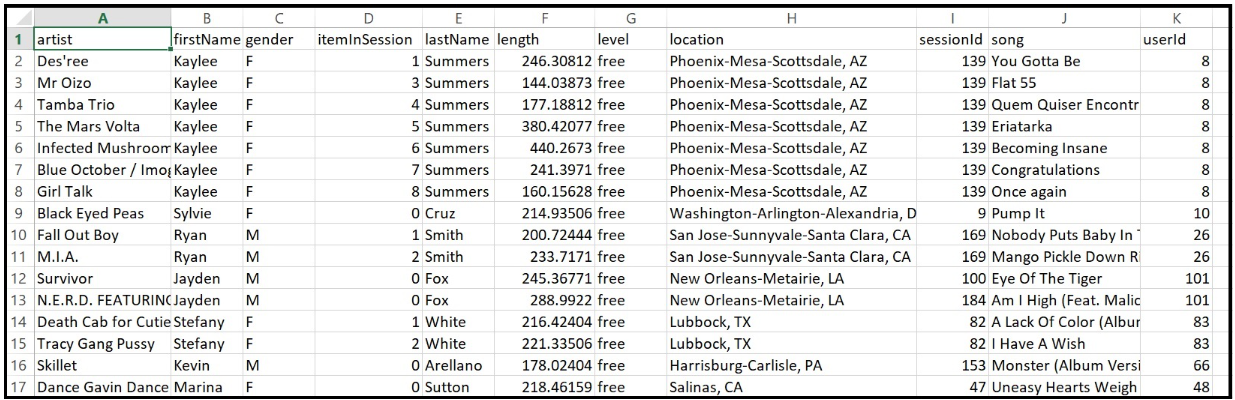

#### Creating a Cluster

In [5]:
# This should make a connection to a Cassandra instance your local machine 
# (127.0.0.1)

from cassandra.cluster import Cluster
cluster = Cluster()

# To establish connection and begin executing queries, need a session
session = cluster.connect()

#### Creating Keyspace

In [6]:
try:
    session.execute("""
    CREATE KEYSPACE IF NOT EXISTS sparkify
    WITH REPLICATION = 
    {'class' : 'SimpleStrategy', 'replication_factor' : 1}
    """)

except Exception as e:
    print(e)

#### Setting Keyspace

In [7]:
try: 
    session.set_keyspace('sparkify')
except Exception as e:
    print(e)

## Create queries to ask the following three questions of the data

### 1. Give me the artist, song title and song's length in the music app history that was heard during  sessionId = 338, and itemInSession  = 4


### 2. Give me only the following: name of artist, song (sorted by itemInSession) and user (first and last name) for userid = 10, sessionid = 182
    

### 3. Give me every user name (first and last) in my music app history who listened to the song 'All Hands Against His Own'




### Query1

return the `artist`, `song title` and `song's length` in the music app history that was heard during `sessionId = 338`, and `itemInSession = 4`

#### Creating table1

In [8]:
query = "CREATE TABLE IF NOT EXISTS song_info_by_session"
query = query + "(sessionId INT, itemInSession INT, artist TEXT, song TEXT, length FLOAT, PRIMARY KEY(sessionId, itemInSession))"
try:
    session.execute(query)
except Exception as e:
    print(e)
                    

#### Setting up the CSV file and assigning each column to the `SELECT` statement

In [9]:
file = 'event_datafile_new.csv'

with open(file, encoding = 'utf8') as f:
    csvreader = csv.reader(f)
    next(csvreader) # skip header
    for line in csvreader:
      # Assign the INSERT statements into the `query` variable
        query = "INSERT INTO song_info_by_session (sessionId, itemInSession, artist, song, length)"
        query = query + "VALUES(%s, %s, %s, %s, %s)"
        ## Assign which column element should be assigned for each column in the INSERT statement.
        session.execute(query, (int(line[8]), int(line[3]), line[0], line[9], float(line[5])))


#### Doing a `SELECT` to verify that the data have been inserted into each table

In [10]:
query = "SELECT artist, song, length FROM song_info_by_session WHERE sessionId = 338 AND itemInSession = 4"
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
for row in rows:
    print(row.artist, row.song, row.length)

Faithless Music Matters (Mark Knight Dub) 495.30731201171875


### Query2

return name of `artist`, `song` **(sorted by itemInSession)** and user `(first and last name)` for `userid = 10`, `sessionid = 182`

#### Creating table2

In [11]:
query = "CREATE TABLE IF NOT EXISTS song_info_by_user_session"
query = query + "(userId INT, sessionId INT, itemInSession INT, artist TEXT, song TEXT, firstName TEXT, lastName TEXT, PRIMARY KEY((userId, sessionId), itemInSession))"
try:
    session.execute(query)
except Exception as e:
    print(e)

#### Setting up the CSV file and assigning each column to the `SELECT` statement

In [12]:
file = 'event_datafile_new.csv'

with open(file, encoding = 'utf8') as f:
    csvreader = csv.reader(f)
    next(csvreader) # skip header
    for line in csvreader:
        # Assign the INSERT statement into the 'query' variable
        query = "INSERT INTO song_info_by_user_session(userId, sessionId, itemInSession, artist, song, firstName, lastName)"
        query = query + "VALUES(%s, %s, %s, %s, %s, %s, %s)"
        session.execute(query, (int(line[10]), int(line[8]), int(line[3]), line[0], line[9], line[1], line[4]))

#### Doing a `SELECT` to verify that the data have been inserted into each table

In [13]:
query = "SELECT artist, song, firstName, lastName FROM song_info_by_user_session WHERE userId = %s AND sessionId = %s"
try:
    rows = session.execute(query, (10,182))
except Exception as e:
    print(e)
for row in rows:
    print(row.artist, row.song, row.firstname, row.lastname)

Down To The Bone Keep On Keepin' On Sylvie Cruz
Three Drives Greece 2000 Sylvie Cruz
Sebastien Tellier Kilometer Sylvie Cruz
Lonnie Gordon Catch You Baby (Steve Pitron & Max Sanna Radio Edit) Sylvie Cruz


### Query3

return every user name **(first and last)** in music app history who listened to the song **'All Hands Against His Own'**

#### Creating table2

In [14]:
query = "CREATE TABLE IF NOT EXISTS user_info_by_song"
query = query + "(song TEXT, userId INT, firstName TEXT, lastName TEXT, PRIMARY KEY(song, userId))"
try:
    session.execute(query)
except Exception as e:
    print(e)

#### Setting up the CSV file and assigning each column to the `SELECT` statement

In [15]:
file = 'event_datafile_new.csv'

with open(file, encoding = 'utf8') as f:
    csvreader = csv.reader(f)
    next(csvreader) # skip header
    for line in csvreader:
        # Assign the INSERT statement into the 'query' variable
        query = "INSERT INTO user_info_by_song(song, userId, firstName, lastName)"
        query = query + "VALUES(%s, %s, %s, %s)"
        session.execute(query, (line[9], int(line[10]), line[1], line[4]))

#### Doing a `SELECT` to verify that the data have been inserted into each table

In [16]:
query = "SELECT firstName, lastName, firstName  FROM user_info_by_song WHERE song = 'All Hands Against His Own'"
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
for row in rows:
    print(row.firstname, row.lastname)

Jacqueline Lynch
Tegan Levine
Sara Johnson


### Drop the tables before closing out the sessions

In [17]:
session.execute("DROP TABLE IF EXISTS song_info_by_session")
session.execute("DROP TABLE IF EXISTS song_info_by_user_session")
session.execute("DROP TABLE IF EXISTS user_info_by_song")

### Close the session and cluster connection¶

In [18]:
session.shutdown()
cluster.shutdown()